In [2]:
# Setup env
!pip install d2l==1.0.0b0
!pip install matplotlib_inline

  Attempting uninstall: gym
    Found existing installation: gym 0.25.2
    Uninstalling gym-0.25.2:
      Successfully uninstalled gym-0.25.2
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
%matplotlib inline
import math
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l
import re

/usr/local/lib/python3.8/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [4]:
### Download H.G Well's Time Machine 
class TimeMachine(d2l.DataModule):
    """The Time Machine dataset."""
    def _download(self):
        fname = d2l.download(d2l.DATA_URL + 'timemachine.txt', self.root,
                             '090b5e7e70c295757f55df93cb0a180b9691891a')
        with open(fname) as f:
            return f.read()

    def _preprocess(self, text):
      return re.sub('[^A-Za-z]+', ' ', text).lower()

data = TimeMachine()
raw_text = data._download()
raw_text[:60]
timemachine = data._preprocess(raw_text)

print(timemachine[:60])

the time machine by h g wells i the time traveller for so it


In [7]:
num_inputs = 2
batch_size = 1
num_hiddens = 10
steps = 100

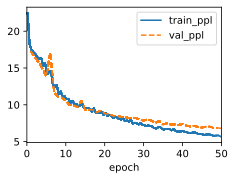

In [15]:
class LSTMScratch(d2l.Module):
  def __init__(self, num_inputs, num_hiddens, sigma = 0.1):
    super().__init__()
    self.save_hyperparameters()

    init_weight = lambda *shape: nn.Parameter(torch.randn(*shape) * sigma)
    triple = lambda: (init_weight(num_inputs, num_hiddens), init_weight(num_hiddens, num_hiddens), nn.Parameter(torch.zeros(num_hiddens)))
    self.W_xi, self.W_hi, self.b_i = triple()#input gate, determine how much information from new C_t
    self.W_xf, self.W_hf, self.b_f = triple()#forget gate, determine how much information from old C_t-1
    self.W_xo, self.W_ho, self.b_o = triple()#output gate, determine how to calculate for output of memory cell
    self.W_xc, self.W_hc, self.b_c = triple()#input node

  def forward(self, inputs, H_C = None):
    if H_C == None:
      #shape = (batch_szie, num_hiddens)
      H = torch.zeros((inputs.shape[1], self.num_hiddens), device = inputs.device)
      C = torch.zeros((inputs.shape[1], self.num_hiddens), device = inputs.device)
    else:
      H,C = H_C

    #calcualte the chart
    outputs = []
    for X in inputs:
      I = torch.sigmoid(torch.matmul(X, self.W_xi) + torch.matmul(H, self.W_hi) + self.b_i)
      F = torch.sigmoid(torch.matmul(X, self.W_xf) + torch.matmul(H, self.W_hf) + self.b_f)
      O = torch.sigmoid(torch.matmul(X, self.W_xo) + torch.matmul(H, self.W_ho) + self.b_o)
      C_tilde = torch.tanh(torch.matmul(X, self.W_xc) + torch.matmul(H, self.W_hc) + self.b_c)
      C = F * C + I * C_tilde
      H = O * torch.tanh(C)
      outputs.append(H)
    
    return outputs, (H,C)
n = 1024
h = 32

steps = 32

data = d2l.TimeMachine(batch_size = n, num_steps = steps)
d = len(data.vocab)
lstm = LSTMScratch(d, h)
model = d2l.RNNLMScratch(lstm, vocab_size=d,lr = 4)
trainer = d2l.Trainer(max_epochs = 50, gradient_clip_val = 1, num_gpus = 1)
trainer.fit(model, data)

In [16]:
model.predict('it has been a ', 20, data.vocab)

'it has been a mome the the the the'